# Airbnb Austin — 02 · Modeling Nightly Price

**Goal:** Predict nightly `price_clean` from engineered features and explain what drives price.
**Inputs:** `data/PROCESSED/listings_features.csv` (from 01 EDA/Features)
**Outputs:** trained model(s), metrics, plots, and saved artifacts in `models/` + `figures/`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# paths
ROOT = Path("..")
PROC = ROOT / "data" / "PROCESSED"
FIGS = ROOT / "figures"
MODELS = ROOT / "models"

for p in [FIGS, MODELS]: p.mkdir(parents=True, exist_ok=True)

print("Using:", PROC)

Using: ..\data\PROCESSED


In [3]:
df = pd.read_csv(PROC / "listings_features.csv")
print(df.shape)
df.head(3)

(5000, 85)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_clean,amenities_count,is_superhost,review_scores_avg,beds_per_guest,price_per_guest
0,1435793082787438351,https://www.airbnb.com/rooms/1435793082787438351,20250613040113,2025-06-13,city scrape,"SoCo Dream Stay | Rooftop, Pool, Gym, Central Loc",Stay in a stylish SoCo apartment just 10 min f...,"The apartment is in South Congress, one of the...",https://a0.muscache.com/pictures/hosting/Hosti...,423445570,...,8,0,0,2.0,130.0,81,1,5.0,0.5,21.666667
1,34792487,https://www.airbnb.com/rooms/34792487,20250613040113,2025-06-14,previous scrape,"Cental Austin - airport, bus and scooters nearby",Quite cozy room with private shower and sink. ...,"Radio Coffee and Beer is down the street, its ...",https://a0.muscache.com/pictures/147695fa-6003...,4710782,...,0,1,0,NaN,NaN,25,0,NaN,NaN,NaN
2,1116702837776875879,https://www.airbnb.com/rooms/1116702837776875879,20250613040113,2025-06-14,previous scrape,Wyndham Austin 2BR sleeps 6,This spacious two-bedroom resort suite measure...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,371942068,...,4,0,0,NaN,NaN,32,1,NaN,NaN,NaN


In [4]:
target = "price_clean"

# start SIMPLE; we can add more features later
features = [
    "amenities_count",
    "is_superhost",
    "review_scores_avg",
    "beds_per_guest",
    "price_per_guest"
]

# keep only rows with all needed values
df_model = df.dropna(subset=[target] + features).copy()
X = df_model[features]
y = df_model[target]

print("Modeling rows:", X.shape[0])
X.head(3)

Modeling rows: 3040


,amenities_count,is_superhost,review_scores_avg,beds_per_guest,price_per_guest
0,81,1,5.000000,0.500,21.666667
4,74,1,4.872857,0.500,90.000000
7,71,1,4.908571,0.375,21.625000


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape

((2432, 5), (608, 5))

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

mae_lin = mean_absolute_error(y_test, pred_lin)
r2_lin  = r2_score(y_test, pred_lin)

print(f"Linear Regression — MAE: ${mae_lin:,.2f} | R²: {r2_lin:.3f}")
print("Coefficients:")
for f, c in zip(features, lin.coef_):
    print(f"{f:>18s}  →  {c: .2f}")

Linear Regression — MAE: $120.16 | R²: 0.271
Coefficients:
   amenities_count  →   3.22
      is_superhost  →   0.29
 review_scores_avg  →   11.15
    beds_per_guest  →   25.07
   price_per_guest  →   2.01


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf  = r2_score(y_test, pred_rf)

print(f"Random Forest — MAE: ${mae_rf:,.2f} | R²: {r2_rf:.3f}")

Random Forest — MAE: $87.29 | R²: 0.706


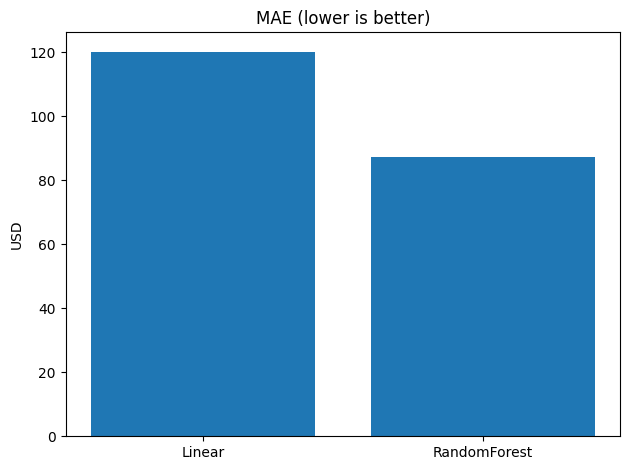

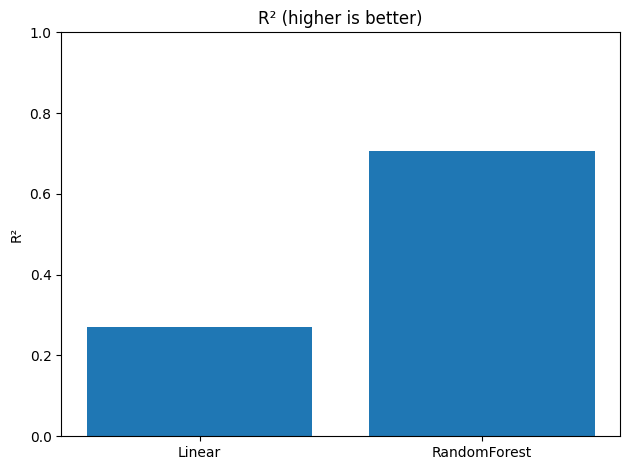

In [8]:
labels = ["Linear", "RandomForest"]
maes   = [mae_lin, mae_rf]
r2s    = [r2_lin, r2_rf]

plt.figure()
plt.bar(labels, maes)
plt.title("MAE (lower is better)")
plt.ylabel("USD")
plt.tight_layout(); plt.savefig(FIGS / "model_mae_compare.png"); plt.show()

plt.figure()
plt.bar(labels, r2s)
plt.title("R² (higher is better)")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.tight_layout(); plt.savefig(FIGS / "model_r2_compare.png"); plt.show()

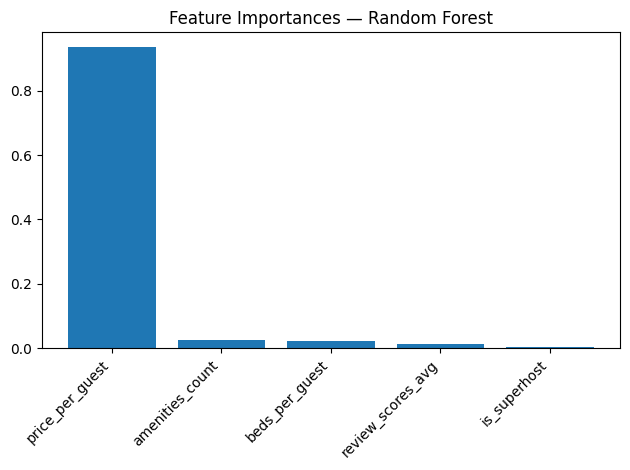

[('price_per_guest', np.float64(0.9342882070462474)),
 ('amenities_count', np.float64(0.02500839867382074)),
 ('beds_per_guest', np.float64(0.02213237770348059)),
 ('review_scores_avg', np.float64(0.013292805051420168)),
 ('is_superhost', np.float64(0.005278211525031195))]

In [9]:
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]

plt.figure()
plt.bar(range(len(order)), importances[order])
plt.xticks(range(len(order)), [features[i] for i in order], rotation=45, ha="right")
plt.title("Feature Importances — Random Forest")
plt.tight_layout(); plt.savefig(FIGS / "rf_feature_importances.png"); plt.show()

list(zip([features[i] for i in order], importances[order]))

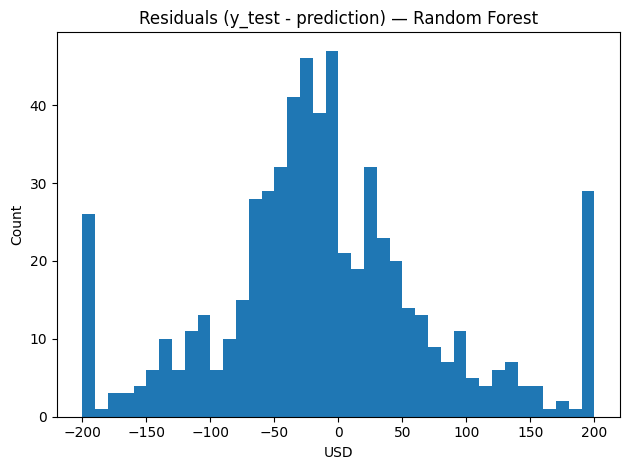

(count     608.000000
 mean      215.197343
 std       239.728999
 min        16.823333
 25%       111.290000
 50%       147.118333
 75%       220.790833
 max      2709.200000
 Name: pred, dtype: float64,
 count     608.000000
 mean      207.383224
 std       310.726671
 min        12.000000
 25%        90.000000
 50%       137.500000
 75%       212.250000
 max      4426.000000
 Name: price_clean, dtype: float64)

In [10]:
resid = y_test - pred_rf
plt.figure()
plt.hist(resid.clip(-200, 200), bins=40)  # clip tails for readability
plt.title("Residuals (y_test - prediction) — Random Forest")
plt.xlabel("USD"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIGS / "rf_residuals.png"); plt.show()

pd.Series(pred_rf, name="pred").describe(), y_test.describe()


In [11]:
import joblib

joblib.dump(rf, MODELS / "rf_price_model.pkl")
out = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_rf": pred_rf,
    "y_pred_lin": pred_lin
})
out.to_csv(PROC / "test_predictions.csv", index=False)

print("Saved model →", MODELS / "rf_price_model.pkl")
print("Saved predictions →", PROC / "test_predictions.csv")

Saved model → ..\models\rf_price_model.pkl
Saved predictions → ..\data\PROCESSED\test_predictions.csv


In [12]:
summary_facts = {
    "rows_used": int(X.shape[0]),
    "features": features,
    "metrics": {
        "linear": {"MAE": float(mae_lin), "R2": float(r2_lin)},
        "random_forest": {"MAE": float(mae_rf), "R2": float(r2_rf)}
    },
    "rf_importances_desc": [
        {"feature": features[i], "importance": float(importances[i])}
        for i in order
    ][:10]
}
summary_facts

{'rows_used': 3040,
 'features': ['amenities_count',
  'is_superhost',
  'review_scores_avg',
  'beds_per_guest',
  'price_per_guest'],
 'metrics': {'linear': {'MAE': 120.15961276384023, 'R2': 0.27054461418234},
  'random_forest': {'MAE': 87.28733214546783, 'R2': 0.7056570467636791}},
 'rf_importances_desc': [{'feature': 'price_per_guest',
   'importance': 0.9342882070462474},
  {'feature': 'amenities_count', 'importance': 0.02500839867382074},
  {'feature': 'beds_per_guest', 'importance': 0.02213237770348059},
  {'feature': 'review_scores_avg', 'importance': 0.013292805051420168},
  {'feature': 'is_superhost', 'importance': 0.005278211525031195}]}

In [13]:
target = "price_clean"
features = ["amenities_count","is_superhost","review_scores_avg",
            "beds_per_guest","price_per_guest"]

df_model = df.dropna(subset=[target] + features).copy()
X = df_model[features]
y = df_model[target]

print("Rows for modeling:", len(df_model))
X.head(3)

Rows for modeling: 3040


,amenities_count,is_superhost,review_scores_avg,beds_per_guest,price_per_guest
0,81,1,5.000000,0.500,21.666667
4,74,1,4.872857,0.500,90.000000
7,71,1,4.908571,0.375,21.625000


Rows for modeling: (3040, 5)

Linear Regression → MAE: $120.16 | R²: 0.271
   amenities_count :  3.22
      is_superhost :  0.29
 review_scores_avg :  11.15
    beds_per_guest :  25.07
   price_per_guest :  2.01

Random Forest → MAE: $87.29 | R²: 0.706


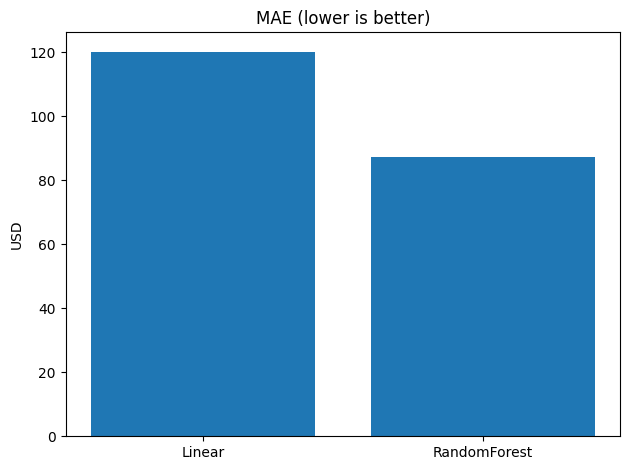

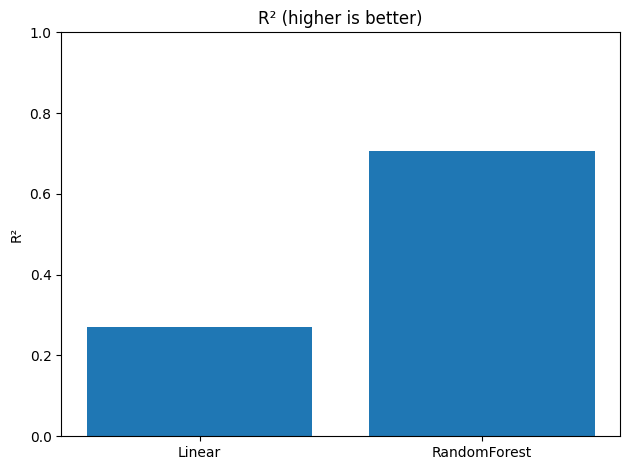

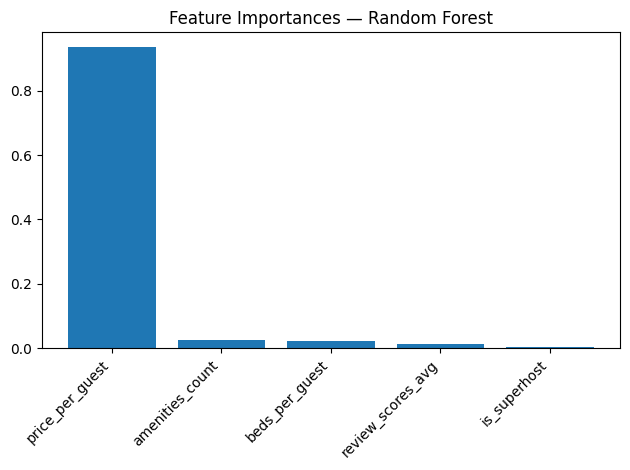


Feature importances:
   price_per_guest : 0.934
   amenities_count : 0.025
    beds_per_guest : 0.022
 review_scores_avg : 0.013
      is_superhost : 0.005

💾 Saved model → ..\models\rf_price_model.pkl
💾 Saved predictions → ..\data\PROCESSED\test_predictions.csv


In [14]:
# ==== Day 4: Modeling nightly price in one go ====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# paths
ROOT = Path("..")
PROC = ROOT / "data" / "PROCESSED"
FIGS = ROOT / "figures"
MODELS = ROOT / "models"
for p in [FIGS, MODELS]: p.mkdir(exist_ok=True)

# 1. Load processed data
df = pd.read_csv(PROC / "listings_features.csv")

# 2. Target & features
target = "price_clean"
features = ["amenities_count","is_superhost","review_scores_avg",
            "beds_per_guest","price_per_guest"]

df_model = df.dropna(subset=[target] + features).copy()
X = df_model[features]
y = df_model[target]
print("Rows for modeling:", X.shape)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 4. Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
mae_lin = mean_absolute_error(y_test, pred_lin)
r2_lin = r2_score(y_test, pred_lin)

print(f"\nLinear Regression → MAE: ${mae_lin:,.2f} | R²: {r2_lin:.3f}")
for f, c in zip(features, lin.coef_):
    print(f"{f:>18s} : {c: .2f}")

# 5. Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print(f"\nRandom Forest → MAE: ${mae_rf:,.2f} | R²: {r2_rf:.3f}")

# 6. Compare metrics (bar plots)
labels, maes, r2s = ["Linear","RandomForest"], [mae_lin,mae_rf], [r2_lin,r2_rf]

plt.figure()
plt.bar(labels, maes); plt.title("MAE (lower is better)")
plt.ylabel("USD"); plt.tight_layout()
plt.savefig(FIGS / "model_mae_compare.png"); plt.show()

plt.figure()
plt.bar(labels, r2s); plt.title("R² (higher is better)")
plt.ylabel("R²"); plt.ylim(0,1); plt.tight_layout()
plt.savefig(FIGS / "model_r2_compare.png"); plt.show()

# 7. Feature importances (RF)
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]

plt.figure()
plt.bar(range(len(order)), importances[order])
plt.xticks(range(len(order)), [features[i] for i in order], rotation=45, ha="right")
plt.title("Feature Importances — Random Forest")
plt.tight_layout()
plt.savefig(FIGS / "rf_feature_importances.png"); plt.show()

print("\nFeature importances:")
for i in order:
    print(f"{features[i]:>18s} : {importances[i]:.3f}")

# 8. Save model + predictions
joblib.dump(rf, MODELS / "rf_price_model.pkl")
preds = pd.DataFrame({"y_true": y_test, "y_pred_lin": pred_lin, "y_pred_rf": pred_rf})
preds.to_csv(PROC / "test_predictions.csv", index=False)

print("\n💾 Saved model →", MODELS / "rf_price_model.pkl")
print("💾 Saved predictions →", PROC / "test_predictions.csv")